In [10]:
import utils
from preprocessing import *
SIZE = 256

In [102]:
img_train, mask_train = prepareDataset(TRAIN_CONTOUR_PATH, TRAIN_IMG_PATH)
img_test, mask_test = prepareDataset(TEST_CONTOUR_PATH, TEST_IMG_PATH)
img_val, mask_val = prepareDataset(VAL_CONTOUR_PATH, VAL_IMG_PATH)

ROI_train = get_ROI(TRAIN_CONTOUR_PATH)
ROI_test = get_ROI(TEST_CONTOUR_PATH)
ROI_val = get_ROI(VAL_CONTOUR_PATH)

Number of examples: 260

Processing 260 images and labels ...

Number of examples: 279

Processing 279 images and labels ...

Number of examples: 266

Processing 266 images and labels ...



In [38]:
img_tv = np.concatenate((img_train, img_val), axis = 0)
roi_tv = np.concatenate((ROI_train, ROI_val), axis = 0)
print(img_tv.shape)
print(roi_tv.shape)

(526, 256, 256, 1)
(526, 32, 32)


In [39]:
def reformDataXY(img, ROI, img_size = 64,  mask_size = 32):
    X = np.zeros((img.shape[0], img_size, img_size, 1))
    for i in range(X.shape[0]):
        X[i,:,:,0] = cv2.resize(img[i,:,:,0], (img_size, img_size), interpolation = cv2.INTER_LINEAR)
    Y = np.array(ROI).reshape((len(ROI),1, mask_size, mask_size))
    return X, Y

In [62]:
X, Y = reformDataXY(img_tv, roi_tv)
X_test, Y_test = reformDataXY(img_test, ROI_test)

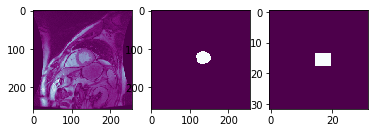

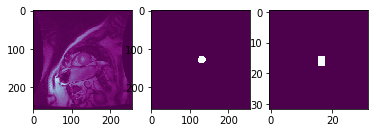

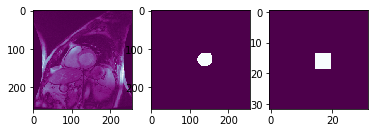

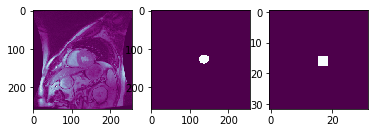

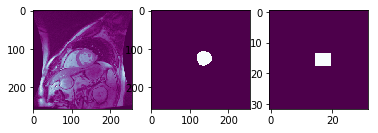

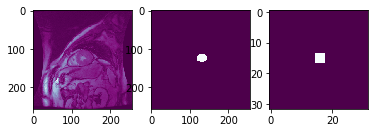

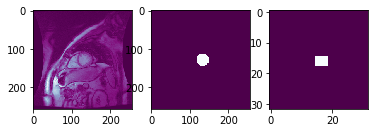

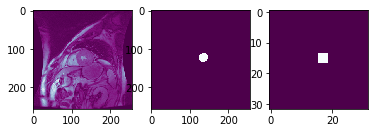

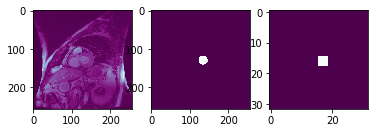

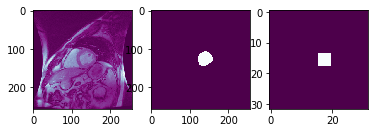

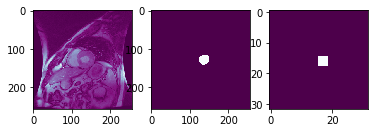

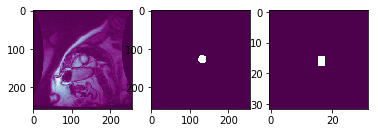

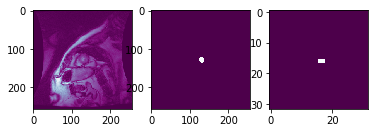

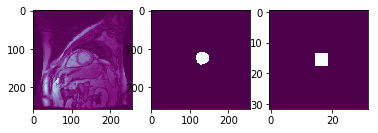

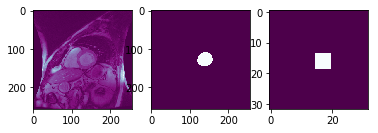

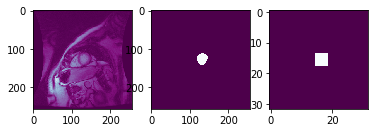

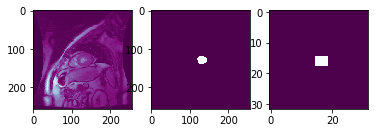

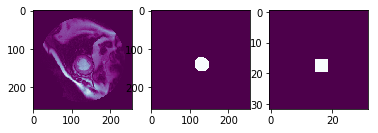

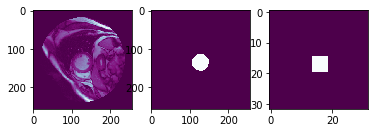

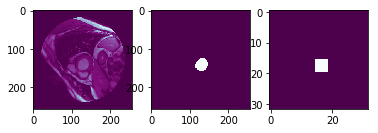

In [13]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
for i in range(20):
    mask = mask_train[i, :, :, 0]
    img = img_train[i, :, :, 0]
    plt.figure()
    plt.subplot(131)
    plt.imshow(img, cmap=plt.cm.BuPu_r)
    plt.subplot(132)
    plt.imshow(mask, cmap=plt.cm.BuPu_r)
    plt.subplot(133)
    plt.imshow(ROI_train[i],cmap=plt.cm.BuPu_r)

(526, 64, 64, 1)
(526, 1, 32, 32)


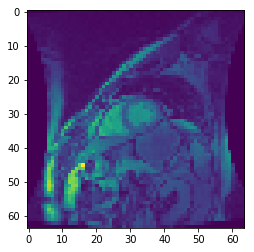

In [43]:
print(X.shape)
print(Y.shape)
plt.imshow(X[0,:,:,0])

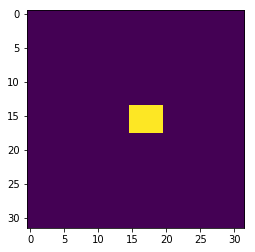

In [17]:
plt.imshow(Y[0,0,:,:])

In [55]:
from baseline_model import *
model = create_model()

Size for each layer :
Layer, Input Size, Output Size
('Conv2D_4', (None, 64, 64, 1), (None, 54, 54, 100))
('Average_Pooling2D_4', (None, 54, 54, 100), (None, 9, 9, 100))
('Reshape_7', (None, 9, 9, 100), (None, 1, 8100))
('Dense_4', (None, 1, 8100), (None, 1, 1024))
('Reshape_8', (None, 1, 1024), (None, 1, 32, 32))


In [61]:
model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics=['accuracy'])
h = training(model, X, Y, batch_size=16, epochs= 10, data_augm=False)

Epoch 1/10
526/526 [==============================] - 8s 15ms/step - loss: 0.0184 - acc: 0.0467
Epoch 2/10
526/526 [==============================] - 7s 14ms/step - loss: 0.0199 - acc: 0.0526
Epoch 3/10
526/526 [==============================] - 7s 14ms/step - loss: 0.0247 - acc: 0.0548
Epoch 4/10
526/526 [==============================] - 7s 13ms/step - loss: 0.0297 - acc: 0.0472
Epoch 5/10
526/526 [==============================] - 7s 13ms/step - loss: 0.0322 - acc: 0.0363
Epoch 6/10
526/526 [==============================] - 7s 13ms/step - loss: 0.0317 - acc: 0.0348
Epoch 7/10
526/526 [==============================] - 8s 14ms/step - loss: 0.0303 - acc: 0.0371
Epoch 8/10
526/526 [==============================] - 7s 14ms/step - loss: 0.0285 - acc: 0.0362
Epoch 9/10
526/526 [==============================] - 7s 14ms/step - loss: 0.0267 - acc: 0.0418
Epoch 10/10
526/526 [==============================] - 7s 14ms/step - loss: 0.0258 - acc: 0.0493


In [63]:
y_pred = model.predict(X_test, batch_size = 16)

In [120]:
print(y_pred.shape)

(279, 1, 32, 32)


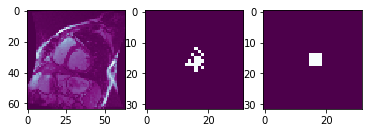

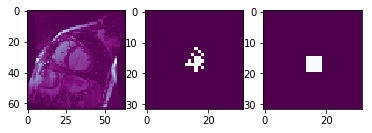

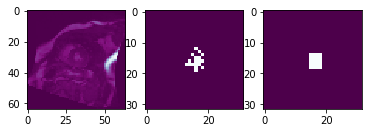

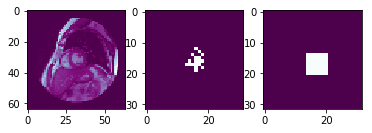

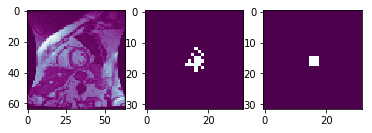

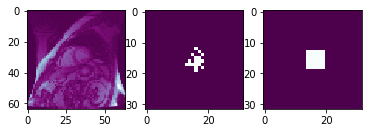

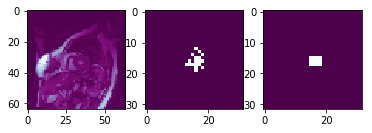

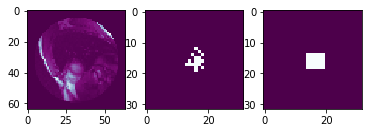

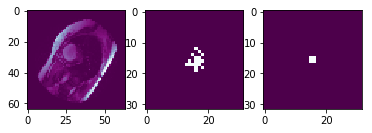

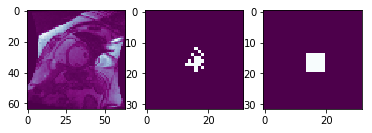

In [67]:
for i in range(10):
    mask = y_pred[i * 20, 0, :, :]
    img = X_test[i * 20, :, :, 0]
    plt.figure()
    plt.subplot(131)
    plt.imshow(img, cmap=plt.cm.BuPu_r)
    plt.subplot(132)
    plt.imshow(mask, cmap=plt.cm.BuPu_r)
    plt.subplot(133)
    plt.imshow(ROI_val[i],cmap=plt.cm.BuPu_r)

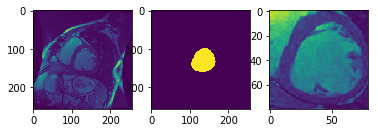

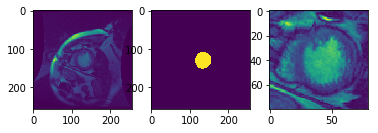

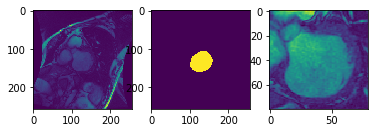

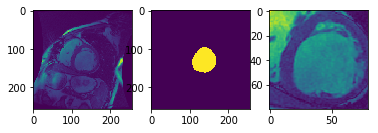

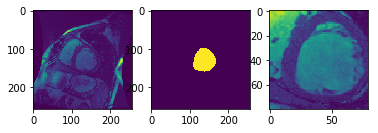

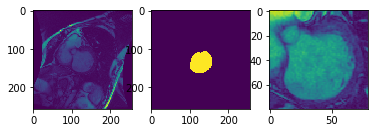

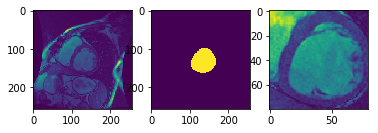

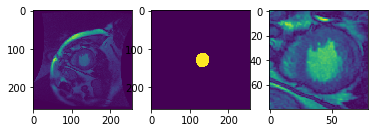

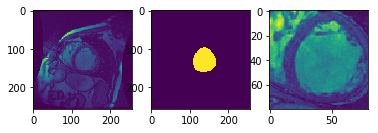

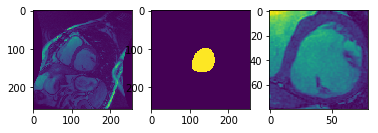

In [202]:
cropped = get_cropped(img_test, y_pred, win_size = 80)
for i in range(10):
    plt.figure()
    plt.subplot(131)
    plt.imshow(img_test[i, :, :, 0])
    plt.subplot(132)
    
    plt.imshow(mask_test[i,:,:,0])
    plt.subplot(133)
    plt.imshow(cropped[i, :,:,0])

In [171]:
from sklearn.metrics import confusion_matrix
def check_diff(mask, pred):
    pred_box = np.zeros((mask.shape))
    n = mask.shape[0]
    for i in range(n):
        [x_min, x_max, y_min, y_max] = get_bbox_single(pred)
        pred_box[i,  x_min:x_max, y_min:y_max, 0] = 1
    pred_box = np.reshape(pred_box, [n, pred_box.shape[1]*pred_box.shape[1]])
    mask = np.reshape(mask, [n, mask.shape[1] * mask.shape[1]])
    #cm = confusion_matrix(mask, pred_box)
    cm = np.zeros((2,2))
    for i in range(n):
        cm = cm + confusion_matrix(mask[i,:], pred_box[i,:])
    cm = cm / n
    return cm
        

In [197]:
def get_bbox_single(pred, roi_size = 32, win_size = 80):
    '''
        Compute the bounding box param of the given binary region mask
        This implementation compute the median of x, y as the middle point.
    '''
    ind = np.array(np.where(pred > 0.5))
    [x_median, y_median] = np.median(region, axis=1)
    x_median *= 256 / roi_size
    y_median *= 256 / roi_size
    x_min = int(max(0, x_median - win_size / 2))
    y_min = int(max(0, y_median - win_size / 2))
    x_max = x_min + win_size
    y_max = y_min + win_size
    return [x_min, x_max, y_min, y_max]

In [198]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.9171405  0.0828595 ]
 [0.00146129 0.99853871]]


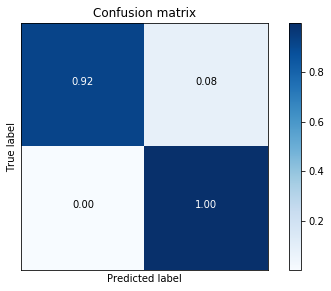

In [205]:
#results on training set
y_true = np.concatenate((mask_train, mask_val), axis = 0)
y_pred = model.predict(X)
cm = check_diff(y_true, y_pred)
plot_confusion_matrix(cm, [], normalize=True)

In [ ]:
#results on test set
y_true = mask_test
y_pred = model.predict(X_test)
cm = check_diff(y_true, y_pred)
plot_confusion_matrix(cm, [], normalize=True)